Importing libraries and setting up environment

In [1]:
import sympy
sympy.init_printing()
import numpy
import pylab
import h5py
import scipy.optimize



# Governing Equations

Mass conservation

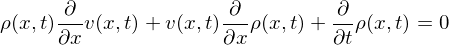

In [2]:
rho = sympy.Function('rho') # Density
v = sympy.Function('v') # Velocity
t = sympy.Symbol('t') # Time
x = sympy.Symbol('x') # Position
mass_conservation = sympy.Eq(sympy.Derivative(rho(x,t), t)+ sympy.Derivative(rho(x,t)*v(x,t),x),0).doit()
mass_conservation

Momentum conservation

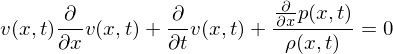

In [3]:
p = sympy.Function('p') # Pressure
momentum_conservation = sympy.Eq(sympy.Derivative(v(x,t),t)+v(x,t)*sympy.Derivative(v(x,t),x)+sympy.Derivative(p(x,t),x)/rho(x,t),0).doit()
momentum_conservation

Entropy conservation

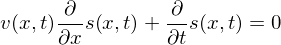

In [4]:
s = sympy.Function('s') # Entropy
entropy_conservation = sympy.Eq(sympy.Derivative(s(x,t),t)+v(x,t)*sympy.Derivative(s(x,t),x),0).doit()
entropy_conservation

Equation of state

In [5]:
gamma = sympy.Symbol('gamma') # Adiabatic index
eos = sympy.Eq(s(x,t), sympy.log(p(x,t))-gamma*sympy.log(rho(x,t)))
eos

# Reduction to dimensionless equations

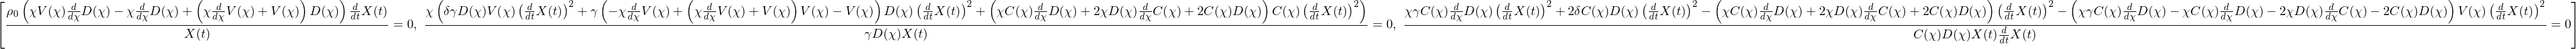

In [6]:
D = sympy.Function('D') # Dimensionless density
rho_0 = sympy.Symbol('rho_0', positive=True) # Upstream density
X = sympy.Function('X') # Position of the shock front
c = sympy.Function('c') # Speed of sound
V = sympy.Function('V') # Dimensionless velocity
C = sympy.Function('C') # Dimensionless speed of sound 
chi = sympy.Symbol('chi') # Dimensionless position
delta = sympy.Symbol('delta') # Shock velocity position power law index
temp = [mass_conservation, momentum_conservation, entropy_conservation.subs(eos.lhs,eos.rhs).doit()]
temp = [itm.subs(p(x,t), rho(x,t)*c(x,t)**2/gamma) for itm in temp]
temp = [itm.subs(rho(x,t), rho_0*D(x/X(t))) for itm in temp]
temp = [itm.subs(v(x,t), X(t).diff(t)*V(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(c(x,t), X(t).diff(t)*C(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(x, chi*X(t)) for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.simplify() for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.subs(X(t).diff(t,2), delta*X(t).diff(t)**2/X(t)) for itm in temp]
dimensionless_equation = temp
dimensionless_equation

solving for the derivatives

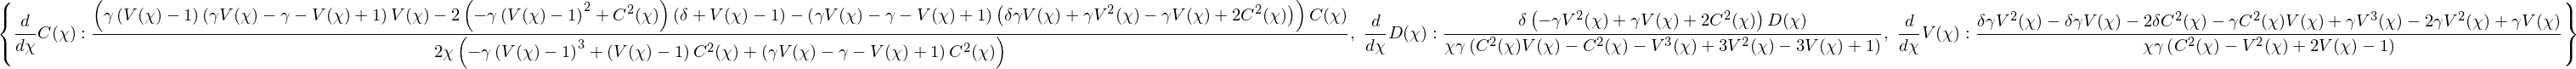

In [29]:
dimles_derivatives = sympy.solve(dimensionless_equation, [v(chi).diff(chi) for v in [D,C,V]])
dimles_derivatives



Safe places to cross the sonic line

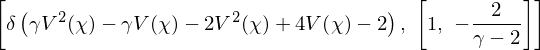

In [8]:
temp = V(chi).diff(chi).subs(dimles_derivatives)
temp = sympy.fraction(temp)[0]
temp = temp.subs(C(chi), 1-V(chi)).simplify()
[temp, sympy.solve(temp, V(chi))]

Formulas for V_shock, C_shock:

In [9]:
V_sonic = 2/(2-gamma)
C_sonic = -gamma/(2-gamma)

It is possible to reduce these ODEs in $\chi$ to just one ode of $C$ vs $V$

In [10]:
V_tilde = sympy.Symbol(r'\tilde{V}')
C_tilde = sympy.Symbol(r'\tilde{C}')
temp = C(chi).diff(chi)/V(chi).diff(chi)
temp = temp.subs(dimles_derivatives)
temp = temp.subs(V(chi), V_tilde)
temp = temp.subs(C(chi), C_tilde)
temp = temp.simplify()
dCdV = temp


Checking dC/dV at sonic for gamma = 7/5 case:

In [11]:
dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
alpha = sympy.Symbol('alpha') #slope of dCdv
temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
temp = temp.subs(dVs, 1e-6).subs(delta, -2./3.).subs(gamma, 7./5.)
slope_solve = sympy.solve(temp - alpha, alpha)
slope_solve[0] #great!

Checking dC/dV at sonic for gamma = 5/3 case:

In [12]:
dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
alpha = sympy.Symbol('alpha') #slope of dCdv
temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
temp = temp.subs(dVs, 1e-6).subs(delta, -0.6).subs(gamma, 5./3.)
slope_solve = sympy.solve(temp - alpha, alpha)
slope_solve[0] #great!

Obtaining the dV/dchi for 7/5 case:

General v-tilde derivexpression


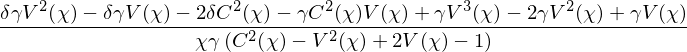

In [13]:
temp = dimles_derivatives[V(chi).diff(chi)]
print("General v-tilde derivexpression")
display(temp)

temp = temp.subs(delta, -2./3.)
temp = temp.subs(gamma, 7./5.)
temp = temp.subs(V(chi), (5.*chi/3. - 5./6.)/chi)
temp = temp.subs(C(chi), (sympy.sqrt(7)*sympy.sqrt(5 - 4*chi))/(6*chi))
temp1 = temp.nsimplify().simplify().subs(chi, -1./2.)
temp1 #seems to be correct!!! now check c...

Obtaining the dC/dchi for 7/5 case:

In [14]:
temp = dimles_derivatives[C(chi).diff(chi)]
#print("General c-tilde deriv expression")
#display(temp)

temp = temp.subs(delta, -2./3.)
temp = temp.subs(gamma, 7./5.)
temp = temp.subs(V(chi), (5.*chi/3. - 5./6.)/chi)
temp = temp.subs(C(chi), (sympy.sqrt(7)*sympy.sqrt(5 - 4*chi))/(6*chi))
temp2 = temp.nsimplify().simplify().subs(chi, -1./2.)
temp2 #yep, c is also right, these are the correct functions.
print("C-tilde deriv:")
display(temp2)
#print("dcdv:")
#temp2/temp1

C-tilde deriv:


Sanity check

In [15]:
temp = sympy.sqrt(sympy.Rational(1,2)*gamma*(gamma-1)*(1-V_tilde)*V_tilde**2/(gamma*V_tilde-1))
temp = dCdV.subs(C_tilde,temp)/temp.diff(V_tilde)
temp = temp.subs(delta,sympy.Rational(-1,2))
temp.simplify()

Slope at the safe sonic point crossing

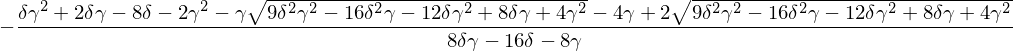

In [16]:
alpha = sympy.Symbol('alpha', positive=True) # Slope
DeltaV = sympy.Symbol(r'\Delta V', positive=True)
temp = dCdV.subs(C_tilde,1-(2/(2-gamma))+alpha*DeltaV)
temp = temp.subs(V_tilde, 2/(2-gamma)+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
sonic_line_slope = sympy.solve(alpha-temp,alpha)[0]
sonic_line_slope


Boundary conditions at the shock front

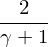

In [17]:
V_shock_front = 2/(gamma+1)
V_shock_front

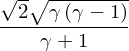

In [18]:
C_shock_front = sympy.sqrt(2*gamma*(gamma-1))/(gamma+1)
C_shock_front

# Shooting method

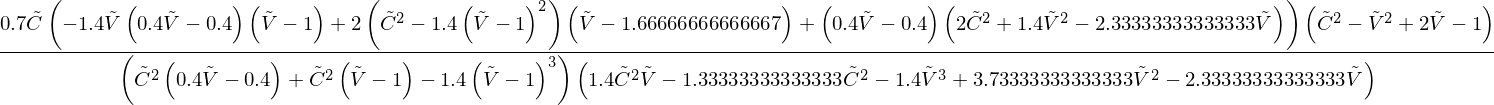

In [19]:
#dCdV.subs({gamma:7./5., V_tilde:10./3. + 1e-1, C_tilde:-7./3. - 1e-1, delta:-2./3.}) 
temp = dCdV.subs({gamma:7./5., delta:-2./3.}) 
temp

<IPython.core.display.Javascript object>


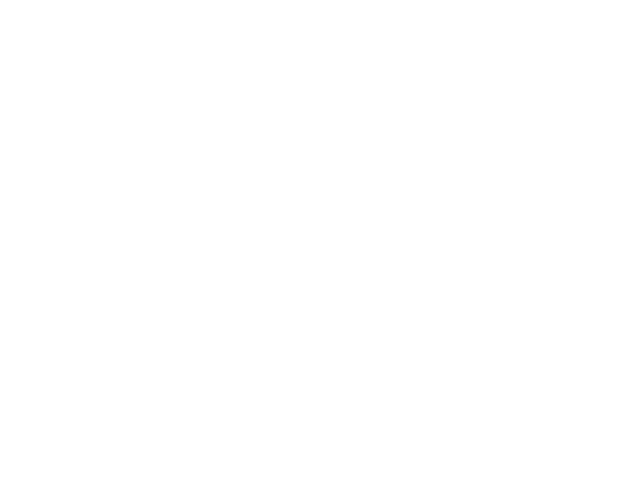

In [20]:
def shoot_from_shock_front(dv, gv):
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    vbc = float(V_shock_front.subs(gamma,gv))
    cbc = float(C_shock_front.subs(gamma,gv))
    v_list = numpy.linspace(vbc, -10.0*vbc,1000)
    c_list = cbc*numpy.ones_like(v_list)
    for n in range(1,len(v_list)):
        dv = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])
    
    # Behind initial impact point
    v_list_2 = numpy.linspace(-v_list[-1],-0.2*v_list[-1], 1000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    for n in range(1, len(v_list_2)):
        dv = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + dv*wrapper(v_list_2[n-1], c_list_2[n-1])
        
    unified_v_list = numpy.concatenate((v_list, [numpy.nan], v_list_2))
    unified_c_list = numpy.concatenate((c_list, [numpy.nan], c_list_2))
    
    return numpy.vstack((unified_v_list, unified_c_list))
%matplotlib notebook
plotfunc = pylab.plot
for dv in numpy.linspace(-0.63,-0.64,5):
    temp = shoot_from_shock_front(dv,5./3.)
    plotfunc(temp[0], temp[1], label=r'$\delta=$'+str(dv))
plotfunc(temp[0], 1-temp[0],'k',label='sonic')
pylab.legend()
pylab.xlabel('V')
pylab.ylabel('C')
pass

In [46]:
def shoot_from_sonic_point(dv, gv): #now deals with both gamma < 2 and gamma>2
    if(gv<2):
        deriv_at_sonic = sonic_line_slope.subs({gamma:gv,delta:dv})
        #finding slope at sonic
        dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
        alpha = sympy.Symbol('alpha') #slope of dCdv
        temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
        temp = temp.subs(dVs, 1e-6).subs(gamma, gv).subs(delta, dv) #uses correct initial value condition for dC/dV at sonic
        slope_solve = sympy.solve(temp - alpha, alpha)
        sonic_slope = slope_solve[0] 
        dV = 1e-6
        V_start = float((2/(2-gamma)).subs(gamma,gv)) + dV
        C_start = float((1-((2/(2-gamma)))).subs(gamma,gv)) + dV * float(sonic_slope)
        v_list = numpy.linspace(V_start, 10*V_start, 10000)
        c_list = C_start*numpy.ones_like(v_list)

        deriv = dCdV.subs({gamma:gv,delta:dv})
        wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)

        for n in range(1,len(v_list)):
            dv = v_list[n] - v_list[n-1]
            c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])

        # Second leg
        vbc = float(V_shock_front.subs(gamma,gv))
        cbc = float(C_shock_front.subs(gamma,gv))    
        v_list_2 = numpy.linspace(-v_list[-1], vbc, 10000)
        c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)

        for n in range(1, len(v_list_2)):
            dv = v_list_2[n] - v_list_2[n-1]
            c_list_2[n] = c_list_2[n-1] + dv*wrapper(v_list_2[n-1], c_list_2[n-1])

        unified_v_list = numpy.concatenate((v_list,[numpy.nan],v_list_2))
        unified_c_list = numpy.concatenate((c_list,[numpy.nan],c_list_2))
        return numpy.vstack((unified_v_list, unified_c_list))
    #for gv>2:

    deriv_at_sonic = sonic_line_slope.subs({gamma:gv,delta:dv})
    #finding slope at sonic
    dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
    alpha = sympy.Symbol('alpha') #slope of dCdv
    temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
    temp = temp.subs(dVs, 1e-6).subs(gamma, gv).subs(delta, dv) #uses correct initial value condition for dC/dV at sonic
    slope_solve = sympy.solve(temp - alpha, alpha)
    sonic_slope = slope_solve[0] 
    dV = 1e-6
    V_start = float((2/(2-gamma)).subs(gamma,gv)) + dV
    C_start = float((1-((2/(2-gamma)))).subs(gamma,gv)) + dV * float(sonic_slope)
    vbc = float(V_shock_front.subs(gamma,gv))
    cbc = float(C_shock_front.subs(gamma,gv))   
    v_list = numpy.linspace(V_start, vbc, 10000)
    c_list = C_start*numpy.ones_like(v_list)

    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)

    for n in range(1,len(v_list)):
        dv = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])

    return numpy.vstack((v_list, c_list))
    



Modifying the above to get a special function which has the root as the correct delta value

In [37]:
def shooter_value(dv, gv):
    
    deriv_at_sonic = sonic_line_slope.subs({gamma:gv,delta:dv})
    #finding slope at sonic
    dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
    alpha = sympy.Symbol('alpha') #slope of dCdv
    temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
    temp = temp.subs(dVs, 1e-6).subs(gamma, gv).subs(delta, dv) #uses correct initial value condition for dC/dV at sonic
    slope_solve = sympy.solve(temp - alpha, alpha)
    sonic_slope = slope_solve[0] #great!
    dV = 1e-6
    V_start = float((2/(2-gamma)).subs(gamma,gv)) + dV
    C_start = float((1-((2/(2-gamma)))).subs(gamma,gv)) + dV * float(sonic_slope)
    v_list = numpy.linspace(V_start, 10*V_start, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        dv = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])
        
    # Second leg
    vbc = float(V_shock_front.subs(gamma,gv))
    cbc = float(C_shock_front.subs(gamma,gv))    
    v_list_2 = numpy.linspace(-v_list[-1], vbc, 10000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    
    for n in range(1, len(v_list_2)):
        dv = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + dv*wrapper(v_list_2[n-1], c_list_2[n-1])
        
    unified_v_list = numpy.concatenate((v_list,[numpy.nan],v_list_2))
    unified_c_list = numpy.concatenate((c_list,[numpy.nan],c_list_2))
    
    return c_list_2[-1] - float(C_shock_front.subs(gamma,gv))



Testing the shooter value function solving for a known solution:

In [38]:
gv = 1.01
def f_function(dv):
    return shooter_value(dv, gv)
scipy.optimize.bisect(f_function, -0.98,-0.5)
#everything is working well!


Having issues with gamma >= 2:

In [ ]:
gv = 2.8
def f_function(dv):
    return shooter_value(dv, gv)
#scipy.optimize.bisect(f_function, -1,-0.5)

#print(shooter_value(-0.5948, 2.8)) #zeldovich results are wrong (this should be be very close to 0 according to Zeldovich)????
#print(scipy.optimize.bisect(f_function, -0.74,-0.73)) #gives solution delta = -0.73375852
#print(scipy.optimize.bisect(f_function, -0.73,-0.71))#gives solution delta = -0.71859226142
shooter_value(-1, 2.8)
#there are two solutions...

Asymptotic behaviour at gamma = 2.01

In [ ]:
gv = 2.01
delta_range = []
output = []

for i in range(49):
    delta_range.append(-0.99 + 0.01*i)
    output.append(shooter_value(-0.99 + 0.01*i, gv))
 
pylab.clf()
pylab.plot(delta_range, output)
pylab.axhline()
pylab.xlabel("Delta")
pylab.ylabel("Shooter value output (equals 0 at the root)")
pylab.savefig("Testing_201_gamma.png")


In [ ]:
output

In [ ]:
gv = 1.01
def f_function(dv):
    return shooter_value(dv, gv)
print(scipy.optimize.bisect(f_function, -0.99, -0.5))

Plotting detla(gamma) plot for 1<gamma<2:

In [ ]:
gamma_list = []

for i in range(100):
    gamma_list.append(1. + 0.01*i)
#gamma_list

results = []

for gv in gamma_list:
    try:
        def f_iterate(dv):
            return shooter_value(dv, gv)
        results.append(scipy.optimize.bisect(f_iterate, -0.98, -0.5))
    except:
        print("ERROR, gamma = " + str(gv))
        results.append(1) #added try, except to catch errors, and keep the rest of the program running!

pylab.clf()
pylab.plot(gamma_list, results)
pylab.xlabel("gamma")
pylab.ylabel("delta")
pylab.savefig("Between_1_and_2")
#working well, now iterate over 10 values or so, store results in a list, then graph


In [ ]:
gamma_list = [] #plotting the results:

for i in range(100):
    gamma_list.append(1. + 0.01*i)
    
results = [-0.953627478405906, -0.8474046988150802, -0.8393031575960777, -0.8250649981073366, -0.8119300130911142, -0.8003341332423588, -0.7900839447156613, -0.7809465616683156, -0.7727276465975592, -0.7652743381750042, -0.7584670509040734, -0.7522113942632132, -0.7464319026712474, -0.7410674291440955, -0.7360677931956161, -0.7313913276138919, -0.7270030628187669, -0.7228733655301767, -0.7189769043525303, -0.7152918535939534, -0.7117992729381513, -0.708482618598282, -0.7053273539549991, -0.7023206364083308, -0.6994510632084712, -0.6967084633924969, -0.6940837261590787, -0.6915686582633498, -0.6891558646912017, -0.6868386482110509, -0.6846109243106184, -0.6824671487756859, -0.6804022556552809, -0.6784116039762011, -0.6764909316389094, -0.67463631544706, -0.6728441362702142, -0.6711110485830432, -0.66943395371527, -0.6678099762884813, -0.6662364434105257, -0.6647108662054961, -0.663230923420997, -0.6617944467670895, -0.6603994078595861, -0.6590439064730162, -0.6577261599868507, -0.6564444939049281, -0.6551973332479974, -0.6539831947939092, -0.6528006800235744, -0.6516484686781041, -0.6505253129307675, -0.6494300320136972, -0.6483615073138935, -0.6473186778584932, -0.6463005361529213, -0.6453061243246339, -0.6443345305615367, -0.6433848857614066, -0.6424563604286959, -0.6415481617241312, -0.6406595306852978, -0.6397897395636392, -0.6389380892778718, -0.6381039069110557, -0.6372865432804247, -0.6364853704926645, -0.6356997794700874, -0.6349291774185986, -0.634172985171972, -0.6334306343287608, -0.6327015641563776, -0.6319852181095484, -0.631281039908572, -0.6305884689154482, -0.629906934709652, -0.6292358504924778, -0.6285746049597947, -0.6279225521157059, -0.6272789982704126, -0.6266431851527159, -0.6260142675655516, -0.6253912833690265, -0.6247731122839468, -0.6241584182735096, -0.6235455671867385, -0.6229325060212432, -0.6223165812461957, -0.6216942565533827, -0.6210606585177811, -0.6204088136164501, -0.6197283007259102, -0.6190027204665967, -0.6182045634468523, -0.6172837214853644, -0.6161381068504852, -0.6145227824072208, -0.6116708908373767, -0.6035146955164237]
pylab.clf()
pylab.plot(gamma_list, results)
pylab.xlabel("gamma")
pylab.ylabel("delta")
pylab.savefig("Between_1_and_2")

Plot graph with varying delta for gamma = 1.01:

In [ ]:
gv = 1.01
delta_range = []
output = []

for i in range(50):
    delta_range.append(-1 + 0.01*i)
    output.append(shooter_value(-1 + 0.01*i, gv))
    
pylab.clf()
pylab.plot(delta_range, output)
pylab.xlabel("Delta")
pylab.ylabel("Shooter value output (equals 0 at the root)")
pylab.savefig("Testing 1_1 case")

In [ ]:
output

Solving the above function for delta, for some gamma values just to see what happens: (for gamma = 2.1, the program fails)

In [ ]:
gamma_list = [2.1]
for gv in gamma_list:
    def f_iterate(dv):
        return shooter_value(dv, gv)
    result = scipy.optimize.bisect(f_iterate, -1, -0.5)
    print(result)
#working well, now iterate over 10 values or so, store results in a list, then graph


In [33]:
shoot_from_sonic_point(-0.666, 17./5.)

'uh oh'

<IPython.core.display.Javascript object>


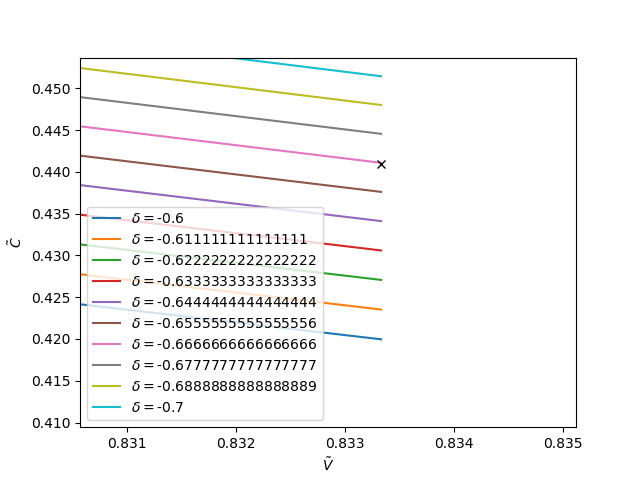

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


In [24]:
%matplotlib notebook
pylab.clf()
for dv in numpy.linspace(-0.6,-0.7,10):
    temp = shoot_from_sonic_point(dv, 7./5.)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,7./5.)),
          float(C_shock_front.subs(gamma,7./5.)),'kx')
pylab.plot(float(V_sonic.subs(gamma,7./5.)),
          float(C_sonic.subs(gamma,7./5.)), marker='o', markersize=3, color="red")
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.legend()
pylab.savefig("75_integration")

<IPython.core.display.Javascript object>


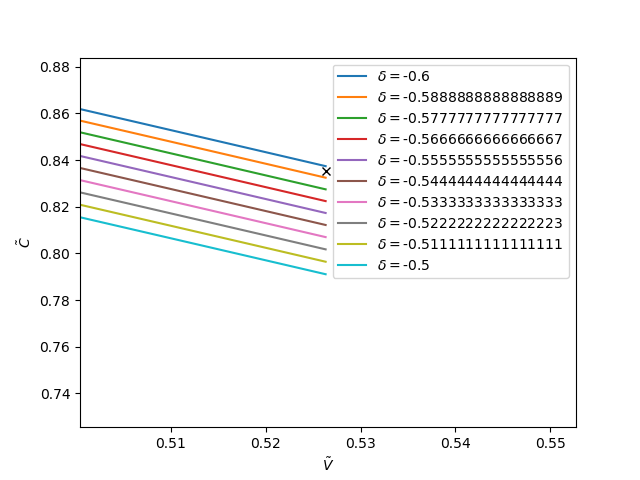

In [45]:
%matplotlib notebook
pylab.clf()
for dv in numpy.linspace(-0.6,-0.5,10):
    temp = shoot_from_sonic_point(dv, 2.8)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,2.8)),
          float(C_shock_front.subs(gamma,2.8)),'kx')
pylab.plot(float(V_sonic.subs(gamma,2.8)),
          float(C_sonic.subs(gamma,2.8)), marker='o', markersize=3, color="red")
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.legend()
pylab.savefig("28_integration")

<IPython.core.display.Javascript object>


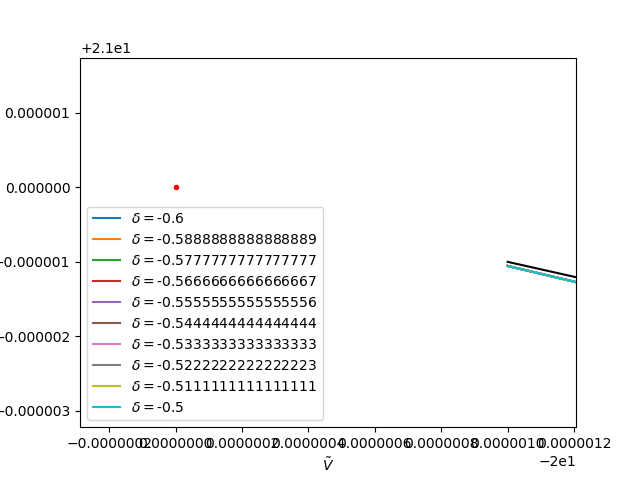

In [47]:
%matplotlib notebook
pylab.clf()
for dv in numpy.linspace(-0.6,-0.5,10):
    temp = shoot_from_sonic_point(dv, 2.1)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,2.1)),
          float(C_shock_front.subs(gamma,2.1)),'kx')
pylab.plot(float(V_sonic.subs(gamma,2.1)),
          float(C_sonic.subs(gamma,2.1)), marker='o', markersize=3, color="red")
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.legend()
pylab.savefig("21_integration")

5/3 case: (works very well)

In [ ]:
%matplotlib notebook
for dv in numpy.linspace(-0.63,-0.64,10):
    temp = shoot_from_sonic_point(dv, 5./3.)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,5./3.)),
          float(C_shock_front.subs(gamma,5./3.)),'kx')
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel('V')
pylab.ylabel('C')
pylab.legend()
print("aa")
print(float(C_shock_front.subs(gamma,5./3.)))

In [ ]:
def phase_space_plot(dv, gv):
    
    v_list = numpy.linspace(-10,10,21)
    c_list = numpy.linspace(-10,10,23)
    V_list, C_list = numpy.meshgrid(v_list, c_list)
    deriv = dCdV.subs({gamma:gv, delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    slopes = wrapper(V_list, C_list)
    SV_list = slopes/numpy.sqrt(slopes**2+1)
    SC_list = 1.0/numpy.sqrt(slopes**2+1)
    %matplotlib notebook
    pylab.quiver(V_list, C_list, SV_list, SC_list)
    
    return None
phase_space_plot(-0.62, 5./3.)